# Gradient descent and optimizers using numpy
In this notebook we will see a way to effectively implement back-propogation we know and love for neural networks in a clean way.
This notebook consist of:
* Dataset generation:
  * The dataset generated are 2d points with a label associated with them.
  * This has been chosen to show the ability of the neural network to fit any custom descision boundry
  * The data is generated in such a way that you can create your own descision boundry condition to be used for data generation
* Defining the layer interface and its subclasses like:
  * nn_layer
  * Activation layers like sigmoid and relu

* Defining the optimizer interface and its subclasses like:
  * SGD
  * RMS_Prop
  * Adam
* Defining the loss function (specifically BinaryCrossEntropy)
* Defining our own Sequential api

This notebook will give you a much deeper understanding and appriciation of tensorflow and keras and empowers you to feel comfertable with designing your own framework



In [ ]:
import tensorflow as tf
print("tf version: ", tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

tf version:  2.8.2


## Dataset generation

The data generation technique is same as the one used in the previous one. You can create your own boundry function by defining a callable object capable of taking a single argument: tensor of dimension (2,) and returning a scalar value indicating whether the point is inside or outside the boundry

In [ ]:
class My_circle_boundry:
  def __init__(self, x_c = 0, y_c = 0, r = 1):
    self.r = r
    self.x_c = x_c
    self.y_c = y_c
    
  
  def __call__(self, x):
    return (x[0] - self.x_c)**2 + (x[1] - self.y_c)**2 - self.r**2
  
# An elliptical boundry
class My_ellipse_boundry:
  def __init__(self, x_c = 0, y_c = 0, a = 1, b = 1):
    
    self.x_c = x_c
    self.y_c = y_c
    self.a = a
    self.b = b 
    
  def __call__(self, x):
    
    return ((x[0] - self.x_c) / self.a)**2 + ((x[1] - self.y_c) / self.b)**2 - 1

# feel free to add your own boundry function/ callable object. 
# Make sure it takes in a tensor shape (2,) and returns a tensor scalar




In [ ]:
def get_y(descision_f, x):
  y = []
  for point in x:
    to_add = bool(descision_f(point) > 0)
    y.append([to_add])
  # print(y)
  return tf.constant(y, dtype = 'int32')


def get_classify_dataset(descision_f, mean_x, scale_x, num_points = 100):
  '''
    Input:
      descision_f: A descision boundry which takes in a 2d tensor of dim [num_points, 2] and returns a tensor of shape [num_points, 1]
      mean_x: The desired distribution mean. A tensor of dim [1, 2]
      scale_x: a multiplicative factor
      num_points: number of desired points
    Outputs:
      x_train: tensor of dim [num_points, 2]
      y_train: tensor of dim [num_points, 1]
  '''

  x_train = (tf.random.uniform((num_points, 2) , minval = -1, maxval = 1) + mean_x) * scale_x  
  y_train = get_y(descision_f, x_train)
  y_train = tf.constant(y_train, dtype = 'int32')

  return x_train, y_train



The below function is responsible for giving the dataset as numpy arrays instead of tensors as we will be using pure numpy in this lab.

In [ ]:
def get_numpy_dataset(descision_f, mean_x, scale_x, num_points = 100):
  mean_x = tf.constant(mean_x, dtype = 'float32')
  x, y = get_classify_dataset(descision_f, mean_x, scale_x, num_points)
  return x.numpy(), y.numpy()

In [ ]:
descision_f = My_ellipse_boundry(a = 2)
mean_x = [0, 0]
scale_x = 2
num_points = 1000 


x_train, y_train = get_numpy_dataset(descision_f, mean_x, scale_x, num_points)

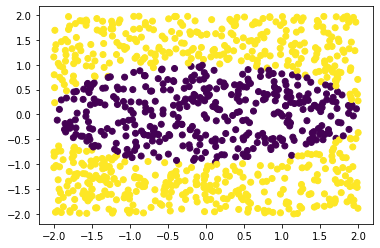

In [ ]:
plt.scatter(x_train[:,0], x_train[:,1], c = y_train)

## Going hardcore with numpy


In [ ]:
# Every class must implement this interface

class Layer:  
  def __call__(self, x):
    '''
    Forward propogates input to generate the output
    '''
    pass
  
  def compute_grad(self,grad_out, x):
    '''
    Using grad_out and x, the gradient of x is computed.
    Returns grad_x which can be used to compute 
    '''
    pass

### The neural network layer

In [ ]:
from tensorflow.python.framework.ops import NotDifferentiable
# defining a neural network layer

class nn_layer(Layer):
  def __init__(self, out_dim, activation = None, optimizer = None):
    
    super().__init__()
    self.out_dim = out_dim
    self.activation = activation
    self.W = None
    self.B = None
    

  def build(self, inputShape):
    inp_dim = inputShape[-1]
    self.W = np.random.normal(size = (inp_dim, self.out_dim))
    self.B = np.random.normal(size = (1, self.out_dim))
  
  def __call__(self, x):
    if self.W is None:
      self.build(x.shape)

    z = np.matmul(x, self.W) + self.B
    if self.activation == None:
      return z
    else:
      return self.activation(z)
  
  def compute_grad(self, grad_out, x):
    '''
    Along with computing dx using grad_out, x, self.dw, self.db is computed so 
    that optimizers can use the same and update self.W and self.B 
    '''

    z = np.matmul(x, self.W) + self.B
    if self.activation != None:
      dz = self.activation.compute_grad(grad_out, z)
    else:
      dz = grad_out
    
    self.dw = np.matmul(np.transpose(x), dz)
    self.db = np.sum(dz, axis = 0, keepdims = True) 

    dx = np.matmul(dz, np.transpose(self.W))
    return dx


In [ ]:
# sanity check
myLayer = nn_layer(5)
out = myLayer(x_train[:10])
print(out.shape)
grad_out = out / 2
grad_in = myLayer.compute_grad(grad_out, x_train[:10])
print(grad_in.shape)
print(myLayer.W.shape, myLayer.dw.shape)
print(myLayer.B.shape, myLayer.db.shape)

(10, 5)
(10, 2)
(2, 5) (2, 5)
(1, 5) (1, 5)


### Various activation layers

In [ ]:
class my_sigmoid(Layer):
  def __call__(self, x):
    return 1/(1 + np.exp(-x))
  
  def compute_grad(self, grad_out, x):
    return grad_out * np.exp(-x) / (1 + np.exp(-x))**2


class my_relu(Layer):

  def __call__(self, x):
    return np.maximum(x, 0)

  def compute_grad(self, grad_out, x):
    ret = np.array(x)
    ret[ret > 0] = 1
    ret[ret <= 0] = 0
    return grad_out * ret  

In [ ]:
# Sanity check
# Testing nn_layer with sigmoid activation
print("Sigmoid test")
sig_acti = my_sigmoid()
relu_acti = my_relu()
myLayer = nn_layer(5, activation = sig_acti)
out = myLayer(x_train[:5])
print(out, out.shape)
d_out = out / 2
grad_in = myLayer.compute_grad(d_out, x_train[:5])
print(grad_in.shape, myLayer.dw.shape, myLayer.db.shape)


# Testing nn_layer with relu activation
print()
print("Relu test")
myLayer.activation = relu_acti
out = myLayer(x_train[:5])
print(out, out.shape)
d_out = out / 2
grad_in = myLayer.compute_grad(d_out, x_train[:5])
print(grad_in.shape, myLayer.dw.shape, myLayer.db.shape)

Sigmoid test
[[0.86158715 0.3259689  0.18181571 0.58907056 0.21278351]
 [0.9084631  0.50376791 0.18743889 0.3828868  0.12976976]
 [0.76651027 0.12877369 0.15890358 0.84950768 0.50252819]
 [0.47039229 0.01921503 0.15017274 0.98204881 0.81841994]
 [0.86664495 0.3472998  0.18500818 0.5614584  0.19092868]] (5, 5)
(5, 2) (2, 5) (1, 5)

Relu test
[[1.82853534 0.         0.         0.36012446 0.        ]
 [2.29501211 0.01507192 0.         0.         0.        ]
 [1.18870998 0.         0.         1.73074493 0.01011287]
 [0.         0.         0.         4.00198488 1.50567892]
 [1.87161426 0.         0.         0.247083   0.        ]] (5, 5)
(5, 2) (2, 5) (1, 5)


### The optimizers
The optimizer is expected to have a __call__ method which takes in current the current gradient 

In [ ]:
class optimizer:
  def __call__(self, cur_grad):
    pass

In [ ]:
class SGD(optimizer):
  def __call__(self, cur_grad):
    return cur_grad

class RMS_Prop(optimizer):
  def __init__(self, beta = 0.9):
    self.v = 0
    self.beta = beta

  def __call__(self, cur_grad):
    self.v = self.beta * self.v + (1 - self.beta) * cur_grad * cur_grad
    return 1/(self.v + 10**-4) ** 0.5 * cur_grad

class Adam(optimizer):
  def __init__(self, beta1 = 0.9, beta2 = 0.9):
    self.v = 0
    self.m = 0
    self.beta1 = beta1
    self.beta2 = beta2

  def __call__(self, cur_grad):
    self.v = self.beta1 * self.v + (1 - self.beta1) * cur_grad * cur_grad
    self.m = self.beta2 * self.m + (1 - self.beta2) * cur_grad

    return 1/(self.v + 10**-4) ** 0.5 * self.m



### Loss function

In [ ]:
class my_BinaryCrossEntropy:
  def getLoss(self, y, y_pred):
    return -(y.T @ np.log(y_pred) + (1 - y).T @ np.log(1 - y_pred)) / y.shape[0]
  
  def compute_grad(self, y, y_pred):
    return -(y / (y_pred + 10**-8) - (1 - y) / (1 - y_pred + 10**-8)) / y.shape[0]

### The sequential model

In [ ]:
from types import MappingProxyType
class my_Sequential:
  def __init__(self, layers_arr ,OPT = [SGD]):
    '''
    layers_arr: an array of layers where the output of the previous layer is input to current layer
    OPT: an array containing the 

    '''
    self.layers_arr = layers_arr
    self.OPT = OPT
    
  def set_optimizers(self):
    self.optimizers_arr = []
    for layer in self.layers_arr:
      if isinstance(layer, nn_layer):

        if len(self.OPT) == 1:
          self.optimizers_arr.append([ self.OPT[0]() for _ in range(2)])
        else:
          self.optimizers_arr.append([ self.OPT[0](*self.OPT[1:]) for _ in range(2)] )
      else:
        self.optimizers_arr.append(None)
  
  
  def __call__(self, x):
    for layer in self.layers_arr:
      x = layer(x)
    return x
  

  def backprop(self, x, y, loss_func, learning_rate):
    y_pred = self(x)
    grad = loss_func.compute_grad(y, y_pred)
    x_arr = []
    for layer in self.layers_arr:
      x_arr.append(x)
      x = layer(x)
    
    for layer, x_in in list(zip(self.layers_arr, x_arr)) [::-1]:
      grad = layer.compute_grad(grad, x_in)
    
    for layer, opt in zip(self.layers_arr, self.optimizers_arr):
      if opt != None:
        dw = layer.dw
        db = layer.db
        update_w = opt[0](dw)
        update_b = opt[1](db)
        layer.W -= learning_rate * update_w
        layer.B -= learning_rate * update_b
  

    
  def fit(self, x, y, loss_func ,learning_rate = 0.001, num_epochs = 5, batch_size = 32):
    self.set_optimizers()
    data_size = x.shape[0]
    for epoch in range(num_epochs):
      
      y_pred = self(x)
      print("Epoch num: %d Loss: %f"%(epoch, loss_func.getLoss(y, y_pred)))
      batch_st = 0
      batch_en = min(batch_size, data_size)

      while batch_st != batch_en:
        
        x_batch = x[batch_st : batch_en]
        y_batch = y[batch_st : batch_en]
        self.backprop(x_batch, y_batch, loss_func, learning_rate)
        batch_st = batch_en
        batch_en = min(data_size, batch_en + batch_size)

In [ ]:
# Using the adam optimizer
m = my_Sequential([
  nn_layer(5, activation = my_relu()),
  nn_layer(5, activation = my_relu()),
  nn_layer(1, activation = my_sigmoid())
], OPT = [RMS_Prop, 0.9])

pred = m(x_train[:10])
print(pred.shape)

(10, 1)


### Training

In [ ]:
adam =  [Adam, 0.9, 0.9]
rms = [RMS_Prop, 0.9]
sgd = [SGD]
m = my_Sequential([
  nn_layer(5, activation = my_relu()),
  nn_layer(5, activation = my_relu()),
  nn_layer(1, activation = my_sigmoid())
], OPT = rms)

pred = m(x_train[:10])
print(pred.shape)

(10, 1)


In [ ]:
loss_func = my_BinaryCrossEntropy()
learning_rate = 0.01
num_epochs = 20
batch_size = 32
m.fit(x_train, y_train, loss_func, learning_rate, num_epochs, batch_size)

Epoch num: 0 Loss: 0.900037
Epoch num: 1 Loss: 0.613148
Epoch num: 2 Loss: 0.520504
Epoch num: 3 Loss: 0.414181
Epoch num: 4 Loss: 0.307289
Epoch num: 5 Loss: 0.242823
Epoch num: 6 Loss: 0.208092
Epoch num: 7 Loss: 0.187228
Epoch num: 8 Loss: 0.173278
Epoch num: 9 Loss: 0.163360
Epoch num: 10 Loss: 0.156302
Epoch num: 11 Loss: 0.151025
Epoch num: 12 Loss: 0.146751
Epoch num: 13 Loss: 0.143213
Epoch num: 14 Loss: 0.140209
Epoch num: 15 Loss: 0.137509
Epoch num: 16 Loss: 0.135120
Epoch num: 17 Loss: 0.133103
Epoch num: 18 Loss: 0.131000
Epoch num: 19 Loss: 0.128309


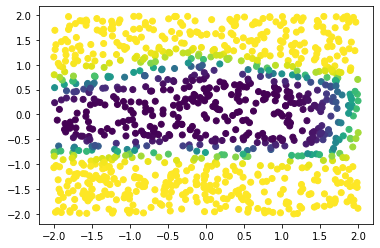

In [ ]:
# Predicted values
y_pred = m(x_train)
plt.scatter(x_train[:,0], x_train[:,1], c = y_pred)

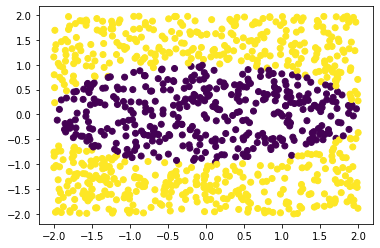

In [ ]:
# Ground truth
plt.scatter(x_train[:,0], x_train[:,1], c = y_train)